# <p style="text-align: center;"> <span style="color:#7a83cc"> In Hospital Mortality Rate

### <span style="color:#7a83cc"> Project Introduction

In this project I will use the "In Hospital Mortality" rate Dataset available on Kaggle to train an XGBoost classifier. This dataset is based on heart faliure patients accepted into a hospital and the survival outcome of these patiens. 
- I will use an XGBClassifier() in combination with an in-training lasso regression to compensate for the imbalance in this dataset.
- The dataset is available on:
https://www.kaggle.com/saurabhshahane/in-hospital-mortality-prediction/code
- One main purpose is to work with an unbalanced dataset and compare a pretraining oversampling method(SMOTE) with an in-training lasso regression that penalizes the minority class.

### <span style="color:#7a83cc"> Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')

In [2]:
# We will be using this randok state for the entire project
RANDOM_STATE = 97

###  <span style="color:#7a83cc"> Importing the Dataset

In [3]:
icu = pd.read_csv('icu.csv',index_col='ID')
icu.shape

(1177, 50)

In [4]:
icu.head()

,group,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
ID,,,,,,,,,,,,,,,,,,,,,
125047,1,0.0,72,1,37.588179,0,0,0,1,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
139812,1,0.0,75,2,NaN,0,0,0,0,1,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
109787,1,0.0,83,2,26.572634,0,0,0,0,1,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
130587,1,0.0,43,2,83.264629,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
138290,1,0.0,75,2,31.824842,1,0,0,0,1,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [5]:
icu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 125047 to 107636
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1177 non-null   int64  
 1   outcome                   1176 non-null   float64
 2   age                       1177 non-null   int64  
 3   gendera                   1177 non-null   int64  
 4   BMI                       962 non-null    float64
 5   hypertensive              1177 non-null   int64  
 6   atrialfibrillation        1177 non-null   int64  
 7   CHD with no MI            1177 non-null   int64  
 8   diabetes                  1177 non-null   int64  
 9   deficiencyanemias         1177 non-null   int64  
 10  depression                1177 non-null   int64  
 11  Hyperlipemia              1177 non-null   int64  
 12  Renal failure             1177 non-null   int64  
 13  COPD                      1177 non-null   int64  
 14  h

In [6]:
icu.corr()

,group,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
group,1.000000,-0.024220,0.000077,0.011808,-0.041432,-0.052413,-0.002997,0.005263,0.025042,0.006558,...,0.013817,0.040122,0.004602,0.008807,0.023504,-0.068841,0.003457,0.008740,0.006578,-0.012091
outcome,-0.024220,1.000000,0.064510,-0.022690,-0.062086,-0.072441,0.100975,-0.014694,-0.049997,-0.099513,...,-0.066366,-0.184071,0.059834,0.229676,0.074033,-0.150611,-0.222650,0.229695,-0.049517,-0.024138
age,0.000077,0.064510,1.000000,0.081705,-0.384185,0.177060,0.291003,0.037594,-0.089103,0.015099,...,0.104325,-0.009952,0.138015,-0.004426,0.088315,0.109494,-0.061130,0.006279,-0.127332,0.054400
gendera,0.011808,-0.022690,0.081705,1.000000,0.024556,0.008776,-0.036957,-0.079159,-0.035943,0.080868,...,0.024527,0.061217,0.003008,-0.048100,-0.033931,-0.075880,0.036389,0.008586,0.085396,0.171936
BMI,-0.041432,-0.062086,-0.384185,0.024556,1.000000,-0.032086,-0.118993,-0.063444,0.155664,-0.020931,...,0.050984,0.095782,-0.187950,-0.123465,0.017540,-0.128718,0.290148,-0.094095,0.347994,0.059470
hypertensive,-0.052413,-0.072441,0.177060,0.008776,-0.032086,1.000000,0.006757,0.010040,0.129649,-0.005795,...,0.033276,0.080089,-0.018294,0.067535,0.000580,0.023865,0.011035,-0.021776,-0.008208,0.012697
atrialfibrillation,-0.002997,0.100975,0.291003,-0.036957,-0.118993,0.006757,1.000000,-0.003449,-0.013032,-0.097414,...,-0.026506,0.019478,0.023312,0.049712,0.067448,0.047849,-0.071813,0.048939,-0.102525,0.011168
CHD with no MI,0.005263,-0.014694,0.037594,-0.079159,-0.063444,0.010040,-0.003449,1.000000,0.008831,0.043327,...,-0.071097,0.021364,-0.056855,0.024763,0.016926,0.072852,-0.009349,0.011653,-0.070955,-0.146272
diabetes,0.025042,-0.049997,-0.089103,-0.035943,0.155664,0.129649,-0.013032,0.008831,1.000000,0.061274,...,0.030363,0.077910,-0.028450,0.037494,0.017670,-0.022938,0.043975,0.034829,0.068339,-0.025660
deficiencyanemias,0.006558,-0.099513,0.015099,0.080868,-0.020931,-0.005795,-0.097414,0.043327,0.061274,1.000000,...,-0.008358,-0.048439,0.064916,-0.016435,0.025365,0.009763,-0.059061,-0.116348,-0.078454,-0.031596


###  <span style="color:#7a83cc"> Dataset Splitting

First we will split the model into the labels and a feature matrix. In the feature matrix we will drop 2 columns, the `group` and the `outcome`.

In [7]:
all_cols = icu.columns
selected_cols = [ 'age', 'gendera', 'BMI', 'hypertensive',
       'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias',
       'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate',
       'Systolic blood pressure', 'Diastolic blood pressure',
       'Respiratory rate', 'temperature', 'SP O2', 'Urine output',
       'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte',
       'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen',
       'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium',
       'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate',
       'Lactic acid', 'PCO2', 'EF']

In [8]:
X_main = icu.iloc[:][selected_cols]
y_main = icu['outcome']

X_main.head()

,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
ID,,,,,,,,,,,,,,,,,,,,,
125047,72,1,37.588179,0,0,0,1,1,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
139812,75,2,NaN,0,0,0,0,1,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
109787,83,2,26.572634,0,0,0,0,1,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
130587,43,2,83.264629,0,0,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
138290,75,2,31.824842,1,0,0,0,1,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, 
                                                  test_size=0.2,
                                                   shuffle=True,
                                                   random_state= RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25)

X_main.shape, X_train.shape

((1177, 48), (705, 48))

In [10]:
training_shapes = X_train.shape[0], y_train.shape[0], X_val.shape[0], y_val.shape[0], X_test.shape[0], y_test.shape[0]
training_shapes2 = pd.DataFrame(training_shapes, columns = ['Test Splits'], index=(['X_train','y_train','X_val','y_val','X_test','y_test']))
training_shapes2.head(6)

,Test Splits
X_train,705
y_train,705
X_val,236
y_val,236
X_test,236
y_test,236


###  <span style="color:#7a83cc"> Feature Engineering and Feature Selection

In the following section I will do the following:
- Impute missing values with column means using the ColumnTransfomer pipeline.
- Perform an ordinary least squares analysis for feature selection and drop the unnecessary columns.

In [11]:
selected_cols_binary = ['gendera', 'hypertensive',
       'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias',
       'depression', 'Hyperlipemia', 'Renal failure', 'COPD']

In [12]:
selected_cols_float = [ 'age', 'BMI', 'heart rate',
       'Systolic blood pressure', 'Diastolic blood pressure',
       'Respiratory rate', 'temperature', 'SP O2', 'Urine output',
       'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte',
       'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen',
       'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium',
       'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate',
       'Lactic acid', 'PCO2', 'EF']

In [13]:
X_train.iloc[:][selected_cols_binary]

,gendera,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD
ID,,,,,,,,,,
193313,2,1,0,0,1,1,0,1,0,0
179493,2,0,0,0,1,0,0,0,0,0
154415,1,1,1,1,0,0,0,0,0,0
108738,2,1,1,0,0,0,0,1,1,0
196986,1,1,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
130179,2,0,0,0,0,1,0,0,1,1
145043,1,1,0,0,0,1,0,0,0,0
186138,1,0,1,0,0,0,0,0,0,0


In [14]:
ct = ColumnTransformer([
    ('simple_impute_binary',SimpleImputer(strategy = 'most_frequent'),selected_cols_binary),
    #('one_hot_encode',OneHotEncoder(drop='first'), selected_cols_binary),
    ('simple_impute_float',SimpleImputer(),selected_cols_float),
])

In [15]:
X_train_FE = ct.fit_transform(X_train)
X_test_FE = ct.transform(X_test)
X_val_FE = ct.transform(X_val)

In [16]:
X_train_FE.shape

(705, 48)

In [17]:
# There is an NAN value, we replace it with the MODE of the set, which is 0
y_train.fillna(value=0,inplace=True)

###  <span style="color:#7a83cc"> Models and Scoring

#### I. Random Forrest Classifier

In [18]:
# penalizes error in minority class
tree_classif = RandomForestClassifier()

In [19]:
tree_classif.fit(X_train_FE,y_train)

RandomForestClassifier()

In [20]:
y_val.fillna(value=0,inplace=True)

In [21]:
# Cross validation:
kf = KFold(n_splits=10)
cross_accuracy = cross_val_score(tree_classif,X_train_FE,y_train,cv=kf,scoring='precision')

In [22]:
# high variancy -> more data for training set
cross_accuracy

array([1., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

#### II. XGB Classifier with In-Training Dataset Balancing

In [23]:
# 'reg:squarederror'
# Used log regression for this classification problem 
# Set slpha to 8(Lasso regression) to penalize errors in the minority class
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', learning_rate = 0.1,
                max_depth = 13, alpha = 8,random_state=RANDOM_STATE)

In [24]:
xg_reg.fit(X_train_FE,y_train)

XGBClassifier(alpha=8, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=97, reg_alpha=8,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
kf2 = KFold(n_splits=10)

In [26]:
scores = cross_val_score(xg_reg, X_test_FE, y_test, cv = kf2)

In [27]:
scores

array([0.83333333, 0.83333333, 0.75      , 0.91666667, 0.91666667,
       0.875     , 0.86956522, 0.91304348, 0.73913043, 0.86956522])

[[200   1]
 [ 28   7]]


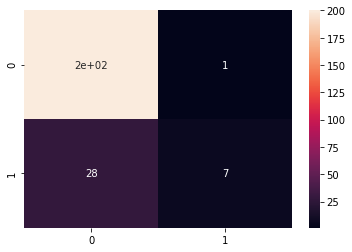

In [28]:
ypred = xg_reg.predict(X_test_FE)
cm = confusion_matrix(y_test,ypred) 
sns.heatmap(cm, annot=True)
print(cm)

In [29]:
precision_xg = metrics.precision_score(y_test,ypred,pos_label=1)
print(precision_xg)

0.875


In [30]:
cm2 = metrics.recall_score(y_test,ypred,pos_label=1)
print(cm2)

0.2


In [31]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

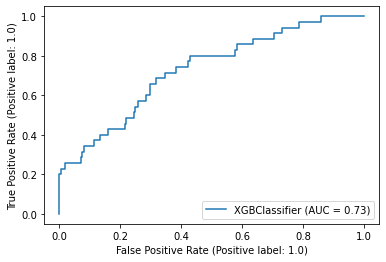

In [32]:
_=plot_roc_curve(xg_reg, X_test_FE, y_test)

#### II. XGB Classifier with Pre-Training Dataset Balancing using SMOTE

In [33]:
from imblearn.over_sampling import SMOTE

In [34]:
sm = SMOTE(sampling_strategy={1:10000}, random_state=RANDOM_STATE)

In [35]:
X_smote, y_smote = sm.fit_resample(X_train_FE, y_train)

In [36]:
xgb_class = XGBClassifier(objective ='reg:logistic', learning_rate = 0.1,
                max_depth = 15, alpha = 8,random_state=RANDOM_STATE)

In [37]:
xgb_class.fit(X_smote,y_smote)

XGBClassifier(alpha=8, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=97, reg_alpha=8,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

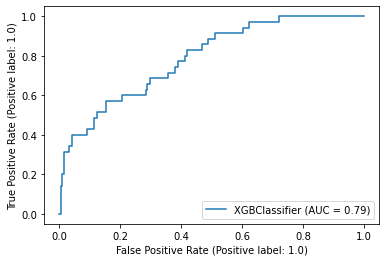

In [38]:
plot_roc_curve(xgb_class, X_test_FE, y_test)

In [39]:
y_smote_pred= xgb_class.predict(X_test_FE)

In [40]:
precision_xg_smote = metrics.precision_score(y_test,y_smote_pred,pos_label=1)

In [41]:
precision_xg_smote

0.37037037037037035

###  <span style="color:#7a83cc"> Discussion